In [1]:
from tracking.analysis import * # custom module which includes my analysis functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
plt.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams.update({'font.size': 9})

age = 13.800797497330507

In [2]:
def read_timescales():
    '''Function to read in the data file which contains quenching and infall times'''
    data = []
    with open('../../Data/QuenchingTimescales.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

def read_timesteps(simname):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(f'../../Data/timesteps_data/{simname}.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    
    data = pd.DataFrame(data)
    return data

In [3]:
path = '../../Data/ram_pressure.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])
print('Available keys:', *keys)

Available keys: h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33


In [7]:
age = 13.800797497330507

path = '../../Data/ram_pressure.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])
print('Running for keys:', *keys)

timescales = read_timescales()

data_all = pd.DataFrame()
i = 1
for key in keys:
    if key=='h242_12' or key=='h148_3': print(f'skipping {key}'); continue;

    print(i, end=' ')
    i += 1
    sim = key[:4]
    haloid = int(key[5:])

    # load ram pressure data
    data = pd.read_hdf(path, key=key)
    # fix data types
    data['Pram_adv'] = np.array(data.Pram_adv,dtype=float)
    data['Pram'] = np.array(data.Pram,dtype=float)
    data['Prest'] = np.array(data.Prest,dtype=float)
    data['ratio'] = data.Pram_adv / data.Prest
    dt = np.array(data.t)[1:] - np.array(data.t)[:-1]
    dt = np.append(dt[0],dt)
    data['dt'] = dt
    
    ts = timescales[(timescales.sim==sim)&(timescales.haloid==haloid)]
    data['tau'] = ts.tinfall.iloc[0] - ts.tquench.iloc[0]    
    data['tquench'] = age - ts.tquench.iloc[0]   

    # load ejected/expelled data
    ejected,cooled,expelled,accreted = read_ejected_expelled(sim, haloid)

    Mgas_div = np.array(data.M_gas,dtype=float)
    Mgas_div = np.append(Mgas_div[0], Mgas_div[:-1])
    
    particles = read_tracked_particles(sim,haloid)
    particles['m_disk'] = np.array(particles.mass,dtype=float)*np.array(particles.sat_disk,dtype=int)
    
    data = pd.merge_asof(data, particles.groupby(['time']).m_disk.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'m_disk':'M_disk'})
    
    Mdisk_div = np.array(data.M_disk,dtype=float)
    Mdisk_div = np.append(Mdisk_div[0], Mdisk_div[:-1])
    
    # first, ejected gas
    data = pd.merge_asof(data, ejected.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_ejected'})
    data['Mdot_ejected'] = data.M_ejected / data.dt
    data['Mdot_ejected_by_Mgas'] = data.Mdot_ejected / Mgas_div
    data['Mdot_ejected_by_Mdisk'] = data.Mdot_ejected / Mdisk_div

    # next, cooled gas
    data = pd.merge_asof(data, cooled.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_cooled'})
    data['Mdot_cooled'] = data.M_cooled / data.dt
    data['Mdot_cooled_by_Mgas'] = data.Mdot_cooled / Mgas_div
    data['Mdot_cooled_by_Mdisk'] = data.Mdot_cooled / Mdisk_div

    # next, expelled gas
    expelled_disk = expelled[expelled.state1=='sat_disk']
    
    data = pd.merge_asof(data, expelled.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_expelled'})
    data['Mdot_expelled'] = data.M_expelled / data.dt
    data['Mdot_expelled_by_Mgas'] = data.Mdot_expelled / Mgas_div

    data = pd.merge_asof(data, expelled_disk.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_expelled_disk'})
    data['Mdot_expelled_disk'] = data.M_expelled_disk / data.dt
    data['Mdot_expelled_disk_by_Mgas'] = data.Mdot_expelled_disk / Mgas_div

    
    # finally, accreted gas
    accreted_disk = accreted[accreted.state2=='sat_disk']
    data = pd.merge_asof(data, accreted.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_accreted'})
    data['Mdot_accreted'] = data.M_accreted / data.dt
    data['Mdot_accreted_by_Mgas'] = data.Mdot_accreted / Mgas_div
    
    data = pd.merge_asof(data, accreted_disk.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_accreted_disk'})
    data['Mdot_accreted_disk'] = data.M_accreted_disk / data.dt
    data['Mdot_accreted_disk_by_Mgas'] = data.Mdot_accreted_disk / Mgas_div
    
    dM_gas = np.array(data.M_gas,dtype=float)[1:] - np.array(data.M_gas,dtype=float)[:-1]
    dM_gas = np.append([np.nan],dM_gas)
    data['Mdot_gas'] = dM_gas / np.array(data.dt)
    
    data['SFR_by_Mgas'] = data.SFR / Mgas_div
    
    data['key'] = key
    data_all = pd.concat([data_all,data])    

Running for keys: h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
1 Returning (ejected, cooled, expelled, accreted) for h148-13...
2 Returning (ejected, cooled, expelled, accreted) for h148-278...
3 Returning (ejected, cooled, expelled, accreted) for h148-28...
4 Returning (ejected, cooled, expelled, accreted) for h148-283...
5 Returning (ejected, cooled, expelled, accreted) for h148-329...
6 Returning (ejected, cooled, expelled, accreted) for h148-37...
7 Returning (ejected, cooled, expelled, accreted) for h148-45...
8 Returning (ejected, cooled, expelled, accreted) for h148-68...
9 Returning (ejected, cooled, expelled, accreted) for h148-80...
10 Returning (ejected, cooled, expelled, accreted) for h229-20...
11 Returning (ejected, cooled, expelled, accreted) for h229-22...
12 Returning (ejected, cooled, expelled, accreted) for h229-23...
13 Returning (ejected, cooled, expelled,

In [5]:
M_gas = np.array(data_all.M_gas,dtype=float)
M_gas_init = np.array([])
for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    t = np.array(d.t)
    mg = np.array(d.M_gas)
    M_gas_init = np.append(M_gas_init, [mg[np.argmin(t)]]*len(d))
    
f_gas = M_gas/M_gas_init
data_all['f_gas'] = f_gas

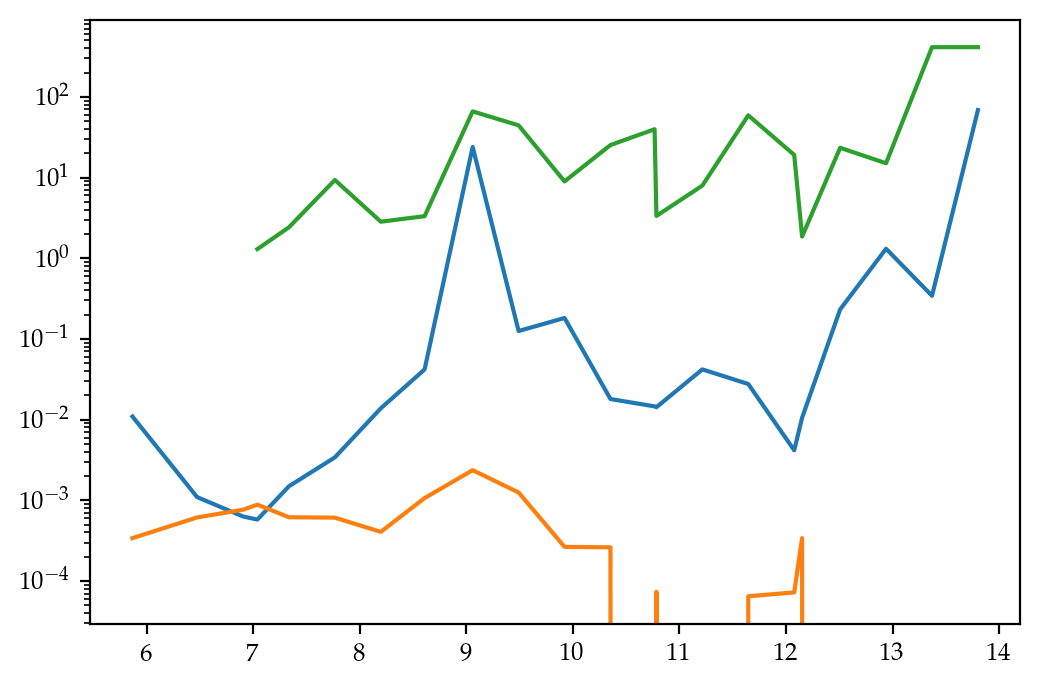

In [12]:
d = data_all[data_all.key=='h148_68']
plt.figure(dpi=200)
plt.plot(d.t, d.ratio)
plt.plot(d.t, d.sfr)
plt.plot(d.t, d.Mdot_expelled/d.Mdot_accreted)
plt.semilogy()
plt.show()

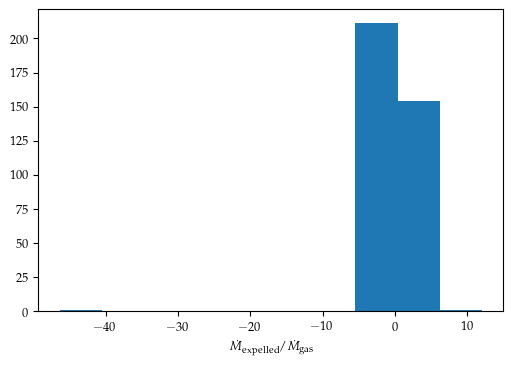

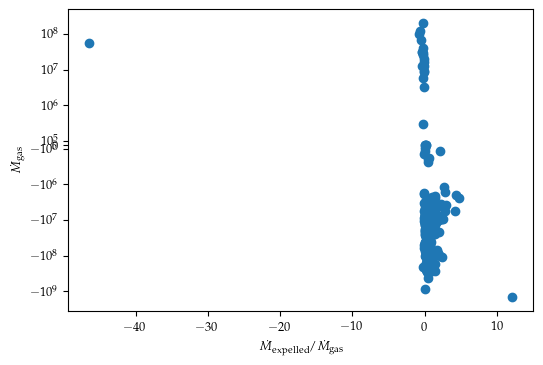

Mdot_expelled/Mdot_gas is only positive is Mdot_gas is positive, i.e. if we are gaining gas


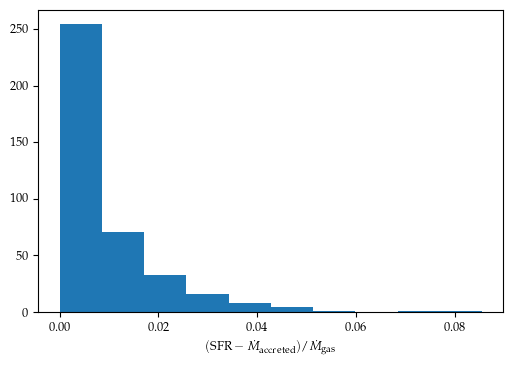

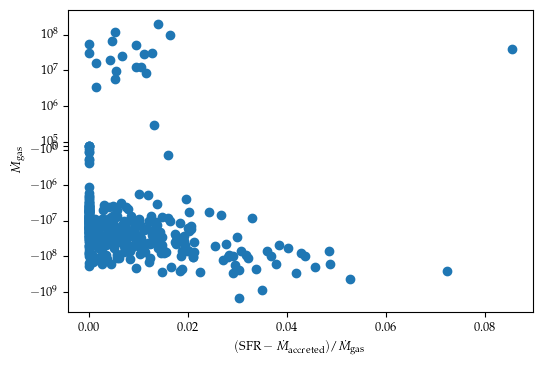

(SFR - Mdot_accreted)/Mdot_gas is only positive is Mdot_gas is positive, i.e. if we are gaining gas


In [28]:
x = data_all.Mdot_expelled_by_Mgas-data_all.Mdot_accreted_by_Mgas
y = data_all.SFR_by_Mgas*1e9
c = data_all.Mdot_gas

fig, ax = plt.subplots(1,1,dpi=100)
ax.hist(x[~np.isinf(x)])
ax.set_xlabel(r'$(\dot{M}_{\rm expelled}-\dot{M}_{\rm accreted})/\dot{M}_{\rm gas}$')
plt.show()

fig, ax = plt.subplots(1,1,dpi=100)
ax.scatter(x, c)
ax.set_xlabel(r'$\dot{M}_{\rm expelled}/\dot{M}_{\rm gas}$')
ax.set_ylabel(r'$\dot{M}_{\rm gas}$')
ax.set_yscale('symlog', linthresh=1e6)
plt.show()

print(f'Mdot_expelled/Mdot_gas is only positive is Mdot_gas is positive, i.e. if we are gaining gas')

fig, ax = plt.subplots(1,1,dpi=100)
ax.hist(y[~np.isinf(y)])
ax.set_xlabel(r'$({\rm SFR} - \dot{M}_{\rm accreted})/\dot{M}_{\rm gas}$')
plt.show()

fig, ax = plt.subplots(1,1,dpi=100)
ax.scatter(y, c)
ax.set_xlabel(r'$({\rm SFR} - \dot{M}_{\rm accreted})/\dot{M}_{\rm gas}$')
ax.set_ylabel(r'$\dot{M}_{\rm gas}$')
ax.set_yscale('symlog', linthresh=1e6)
plt.show()

print(f'(SFR - Mdot_accreted)/Mdot_gas is only positive is Mdot_gas is positive, i.e. if we are gaining gas')


(array([  1.,   0.,   0.,   0.,   0.,   4.,   4., 109.,  15.,   2.]),
 array([-8.50581032e+08, -7.45043479e+08, -6.39505925e+08, -5.33968371e+08,
        -4.28430817e+08, -3.22893264e+08, -2.17355710e+08, -1.11818156e+08,
        -6.28060238e+06,  9.92569514e+07,  2.04794505e+08]),
 <BarContainer object of 10 artists>)

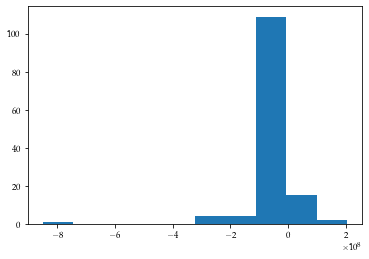

In [84]:
plt.hist(c)

(1e-14, 1e-09)

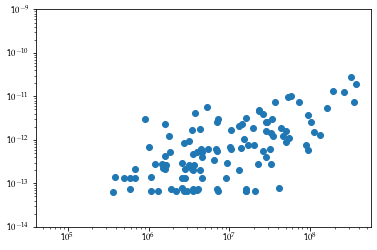

In [104]:

plt.scatter(data_all.Mdot_accreted, data_all.sfr/1e9)
plt.loglog()
plt.ylim(1e-14,1e-9)

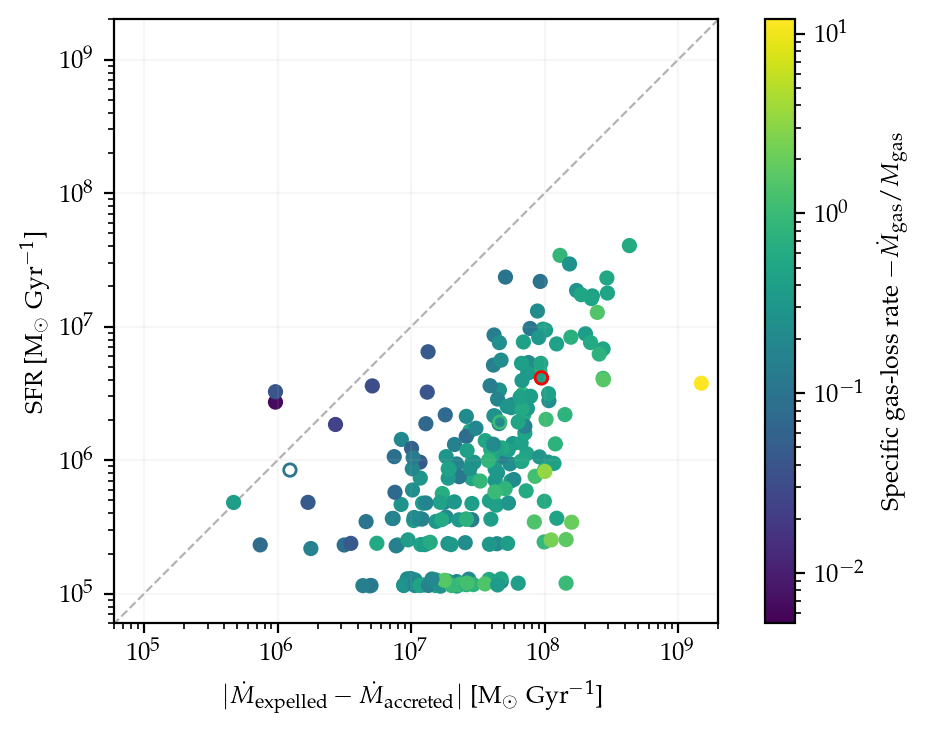

In [6]:
x = (data_all.Mdot_expelled-data_all.Mdot_accreted)
y = data_all.SFR * 1e9
c = data_all.Mdot_gas*data_all.Mdot_ejected_by_Mgas/data_all.Mdot_ejected
norm = mpl.colors.LogNorm()

fig, ax = plt.subplots(1,1,dpi=200)
im = ax.scatter(x,y,c=-c, norm=norm, s=20)

im = ax.scatter(-x,y,c=-c, norm=norm, s=20, fc='none')

cond = (data_all.key == 'h148_68')&(np.abs(data_all.t - 9) < 0.1)
ax.scatter(x[cond],y[cond],ec='r', s=20, fc='none', zorder=1000)

fig.colorbar(im, label=r'Specific gas-loss rate $-\dot{M}_{\rm gas}/M_{\rm gas}$')
ax.set_ylabel(r'SFR [M$_{\odot}$ Gyr$^{-1}$]')
ax.set_xlabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|$ [M$_{\odot}$ Gyr$^{-1}$]')
ax.loglog()
ax.set_ylim(6e4, 2e9)
ax.set_xlim(6e4, 2e9)
ax.plot([1e-3,1e10],[1e-3,1e10],'--', linewidth=0.8, color='0.7', zorder=-1000)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_aspect('equal')
plt.show()

Gas can be 
- ejected from the disk
- cooled onto the disk
- expelled from the disk
- accreted onto the disk
- formed into stars

Net rate of these three things should determine how much gas we are gaining/losing due to gas *flow*, which we can compare to SFR to see if gas consumption is relevant. 

$$\dot{M}_{\rm disk} = \dot{M}_{\rm cooled} + \dot{M}_{\rm accreted,disk} - \dot{M}_{\rm ejected} - \dot{M}_{\rm expelled,disk} - {\rm SFR}$$

To study the role of SFR, we want to determine what fraction of $\dot{M}_{\rm disk}$ is made up by SFR.




When do we use *net gas-loss* rates vs. just *outfow* rates? 

Here, we want to know which is happening faster: gas-loss due to environmental forces or gas-loss due to consumption. 


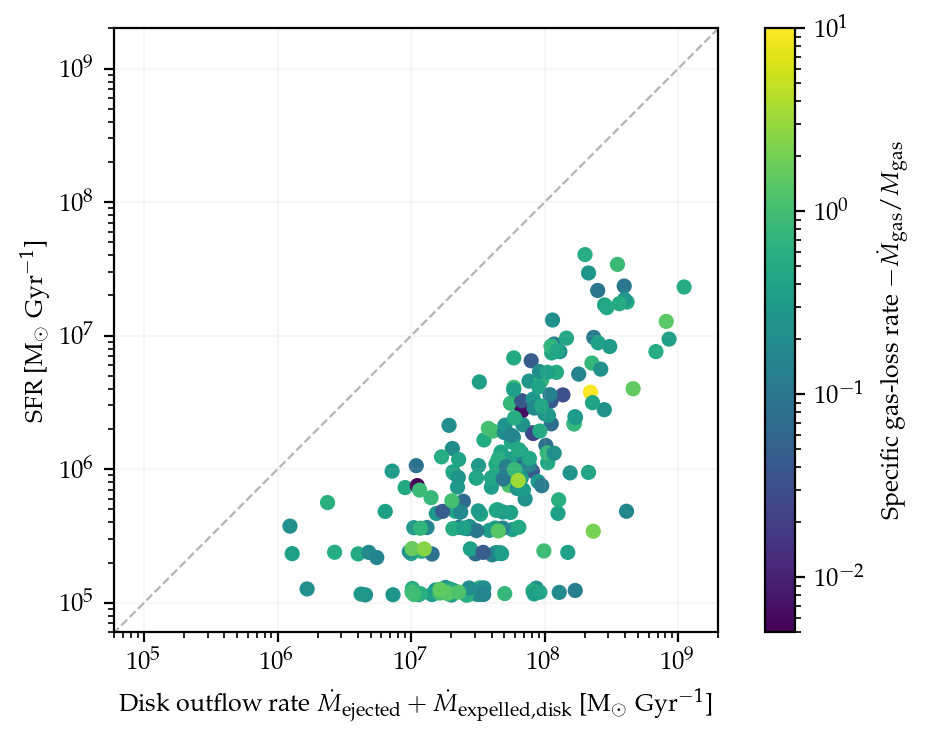

In [16]:
x = data_all.Mdot_ejected + data_all.Mdot_expelled_disk
y = data_all.SFR*1e9
c = data_all.Mdot_gas*data_all.Mdot_ejected_by_Mgas/data_all.Mdot_ejected
norm = mpl.colors.LogNorm(vmin=5e-3, vmax=1e1)

fig, ax = plt.subplots(1,1,dpi=200)
im = ax.scatter(x,y,c=-c, norm=norm, s=20)

fig.colorbar(im, label=r'Specific gas-loss rate $-\dot{M}_{\rm gas}/M_{\rm gas}$')
ax.set_ylabel(r'SFR [M$_{\odot}$ Gyr$^{-1}$]')
ax.set_xlabel(r'Disk outflow rate $\dot{M}_{\rm ejected} + \dot{M}_{\rm expelled,disk} $ [M$_{\odot}$ Gyr$^{-1}$]')
ax.loglog()
ax.set_ylim(6e4, 2e9)
ax.set_xlim(6e4, 2e9)
ax.plot([1e-3,1e10],[1e-3,1e10],'--', linewidth=0.8, color='0.7', zorder=-1000)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_aspect('equal')
plt.show()

In [21]:
x = (data_all.Mdot_cooled + data_all.Mdot_accreted_disk) - (data_all.Mdot_ejected + data_all.Mdot_expelled_disk)
dt = data_all.dt

print(f'When losing material, we lose a total of {np.sum((x*dt)[x<0]):.2e} Msun')
print(f'When gaining material, we gain a total of {np.sum((x*dt)[x>0]):.2e} Msun')

When losing material, we lose a total of -3.16e+09 Msun
When gaining material, we gain a total of 1.03e+09 Msun


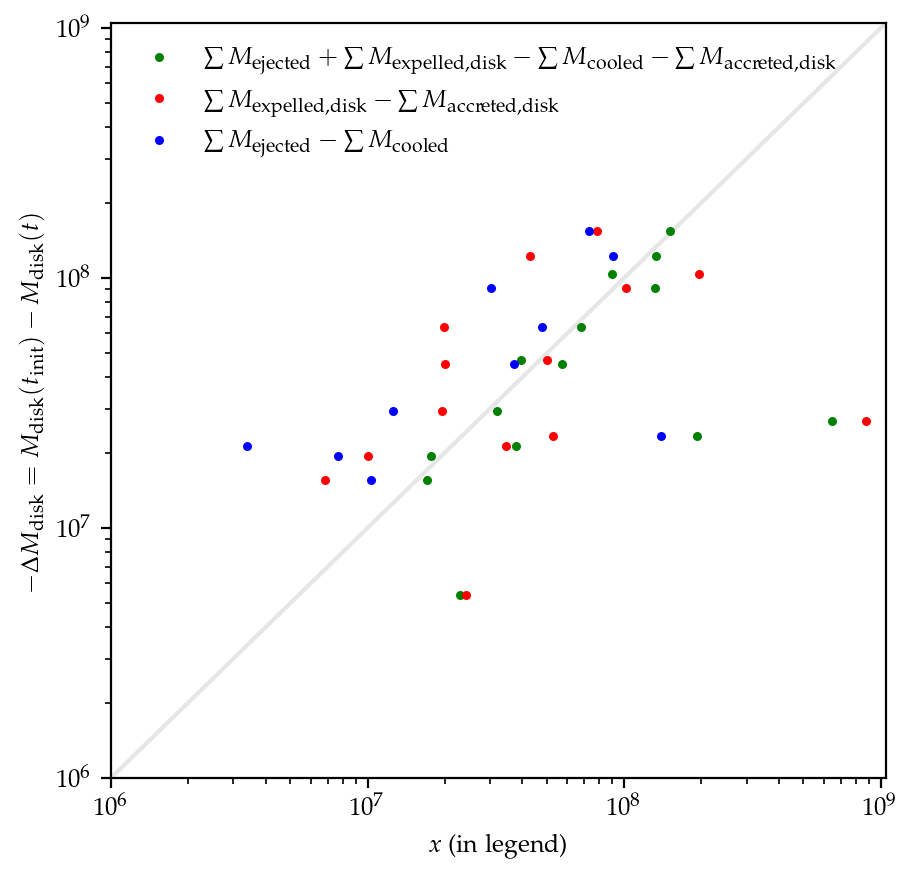

In [56]:
ej_minus_co = np.array([])
ex_minus_ac = np.array([])
delta_Mdisk = np.array([])

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('t')
    
    Mdisk = np.array(d.M_disk,dtype=float)
    delta_Mdisk = np.append(delta_Mdisk, Mdisk[-1]-Mdisk[0])
    ej_minus_co = np.append(ej_minus_co, np.sum(d.M_ejected) - np.sum(d.M_cooled))
    ex_minus_ac = np.append(ex_minus_ac, np.sum(d.M_expelled_disk) - np.sum(d.M_accreted_disk))
    
    
plt.figure(dpi=200, figsize=(5,5))
plt.scatter(ex_minus_ac+ej_minus_co, -delta_Mdisk, s=5, c='g', label=r'$\sum M_{\rm ejected} + \sum M_{\rm expelled,disk} - \sum M_{\rm cooled} - \sum M_{\rm accreted,disk}$')
plt.scatter(ex_minus_ac, -delta_Mdisk, s=5, c='r', label=r'$\sum M_{\rm expelled,disk} - \sum M_{\rm accreted,disk}$')
plt.scatter(ej_minus_co, -delta_Mdisk, s=5, c='b', label=r'$\sum M_{\rm ejected} - \sum M_{\rm cooled}$')
plt.ylabel(r'$-\Delta M_{\rm disk} = M_{\rm disk}(t_{\rm init}) - M_{\rm disk}(t)$')
plt.xlabel(r'$x$ (in legend)')
plt.loglog()
plt.xlim(1e6, 1.05e9)
plt.ylim(1e6, 1.05e9)
plt.legend(frameon=False, loc='upper left')
plt.axline((1e7,1e7),(1e9,1e9), zorder=-100, color='0.9')
plt.show()

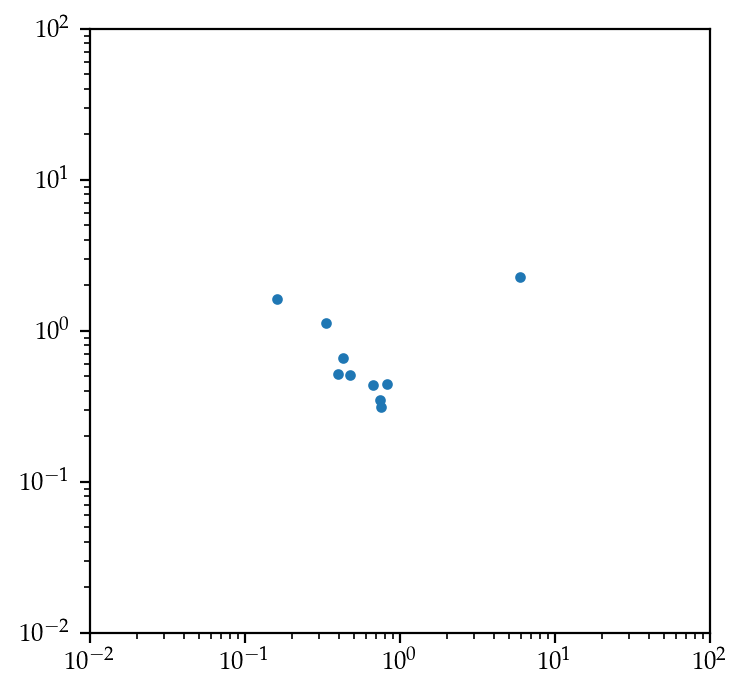

In [57]:
plt.figure(dpi=200, figsize=(4,4))
plt.scatter(-ej_minus_co/delta_Mdisk, -ex_minus_ac/delta_Mdisk, s=8)
plt.loglog()
plt.xlim(1e-2,1e2)
plt.ylim(1e-2,1e2)
plt.show()

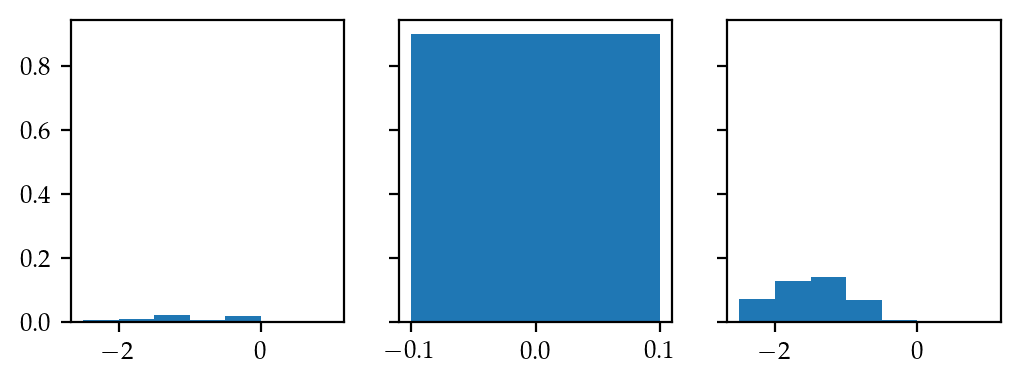

In [160]:
ratio = y/x
ratio = ratio[~np.isnan(ratio)]

weights = np.ones(len(ratio))/len(ratio)


fig, ax = plt.subplots(1,3,figsize=(6,2),dpi=200, sharey=True)

ax[0].hist(np.log10(-ratio), bins = np.arange(-2.5, 1.5, 0.5), weights=weights)
ax[1].hist(ratio, bins=[-0.1,0.1], weights=weights)
ax[2].hist(np.log10(ratio), bins = np.arange(-2.5, 1.5, 0.5), weights=weights)

plt.show()

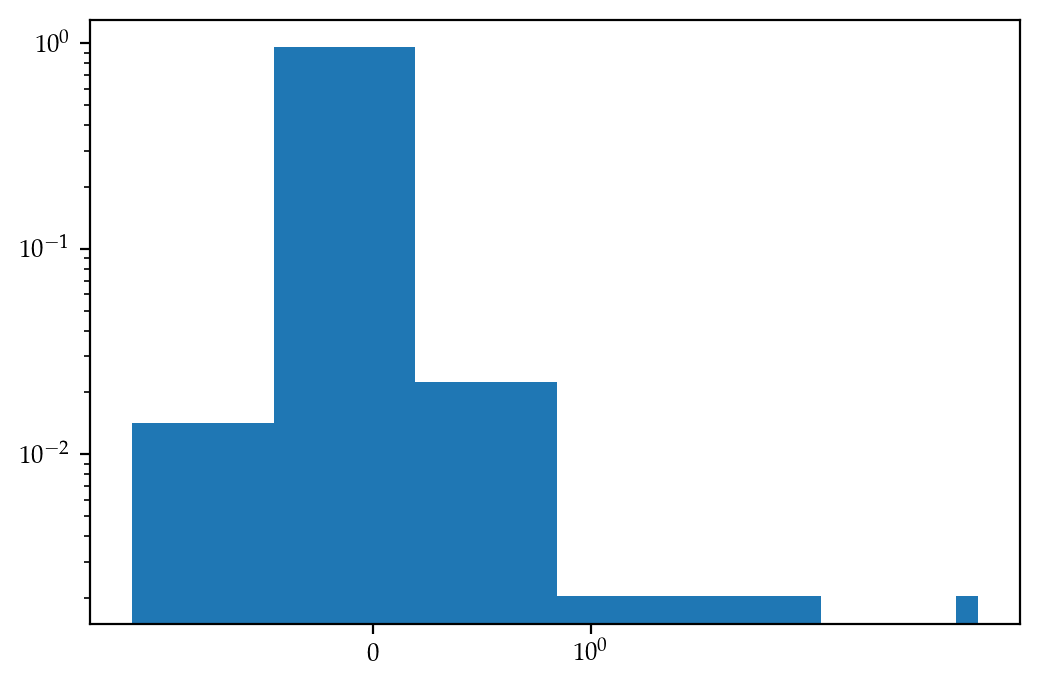

In [164]:
ratio = y/x
ratio = ratio[~np.isnan(ratio)]

weights = np.ones(len(ratio))/len(ratio)

plt.figure(dpi=200)
plt.hist(ratio, weights=weights)
plt.xscale('symlog')
plt.yscale('log')
plt.show()

In [151]:
len(ratio[ratio > 0])

27

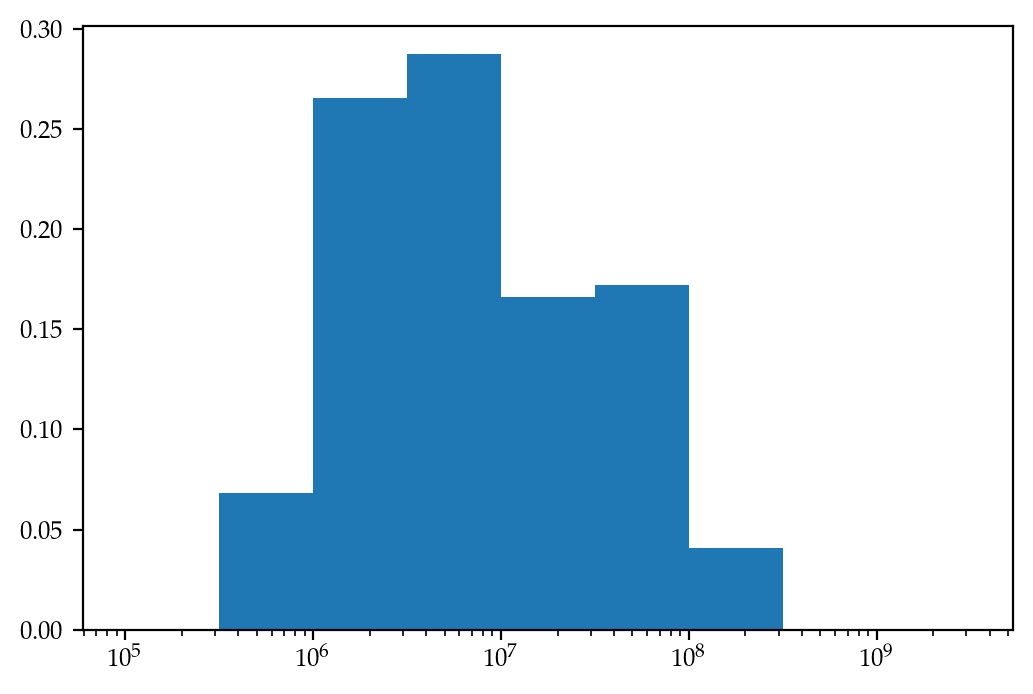

In [135]:
ratio = data_all.M_star

weights = np.ones(len(data_all))/len(data_all)

plt.figure(dpi=200)
y = plt.hist(ratio, bins = np.power(10, np.arange(5, 10, 0.5)), weights=weights)
plt.semilogx()
plt.show()

In [138]:
sum(y[0])

1.0

(array([0.00390625, 0.0078125 , 0.01953125, 0.00390625, 0.015625  ,
        0.00195312, 0.        ]),
 array([3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
        3.16227766e-01, 1.00000000e+00, 3.16227766e+00, 1.00000000e+01]),
 <BarContainer object of 7 artists>)

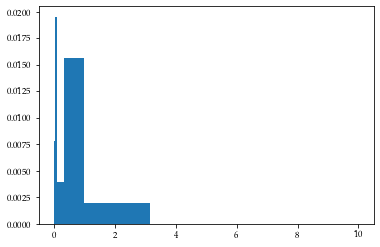

In [127]:
plt.hist(ratio[(ratio != 0)&(~np.isnan(ratio))], bins = np.power(10, np.arange(-2.5, 1.5, 0.5)), weights=weights[(ratio != 0)&(~np.isnan(ratio))])


In [129]:
np.sum(np.array([0.00390625, 0.0078125 , 0.01953125, 0.00390625, 0.015625  ,
        0.00195312, 0.        ]))

0.05273437

In [105]:
x[cond], y[cond]

(6    3.434370e+07
 7    6.518560e+07
 8    6.607769e+07
 dtype: float64,
 6    1.879442e+06
 7    4.137104e+06
 8    2.194788e+06
 Name: SFR, dtype: float64)

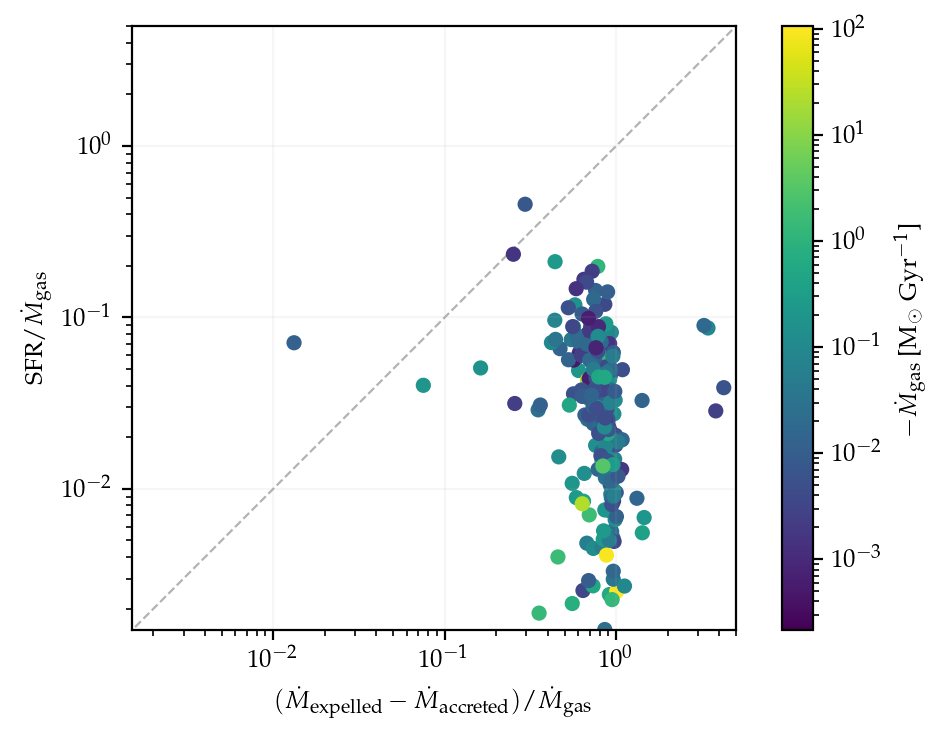

In [51]:
x = (data_all.Mdot_expelled-data_all.Mdot_accreted)/data_all.Mdot_gas
y = data_all.SFR/data_all.Mdot_gas * 1e9
c = data_all.ratio
norm = mpl.colors.LogNorm()

fig, ax = plt.subplots(1,1,dpi=200)
im = ax.scatter(-x,-y,c=c, norm=norm, s=20)
fig.colorbar(im, label=r'$-\dot{M}_{\rm gas}$ [M$_{\odot}$ Gyr$^{-1}$]')
ax.set_ylabel(r'${\rm SFR}/\dot{M}_{\rm gas}$')
ax.set_xlabel(r'$(\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted})/\dot{M}_{\rm gas}$')
ax.loglog()
ax.set_ylim(1.5e-3, 5)
ax.set_xlim(1.5e-3,5)
ax.plot([1e-3,10],[1e-3,10],'--', linewidth=0.8, color='0.7', zorder=-1000)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_aspect('equal')
plt.show()

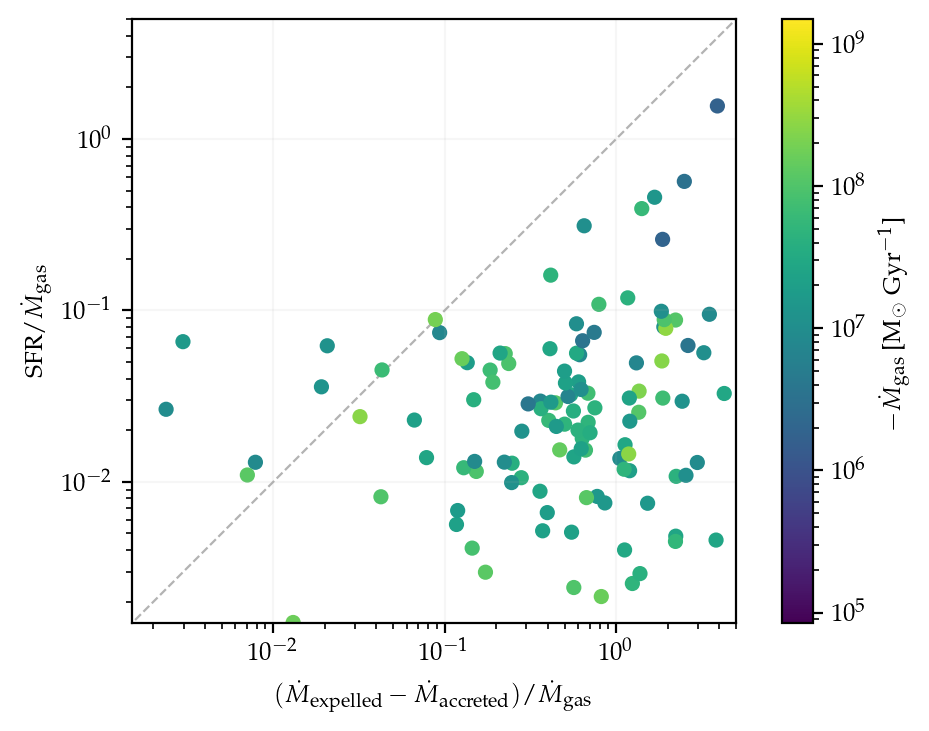

In [55]:
x = (data_all.Mdot_ejected-data_all.Mdot_cooled)/data_all.Mdot_gas
y = data_all.SFR/data_all.Mdot_gas * 1e9
c = data_all.Mdot_gas
norm = mpl.colors.LogNorm()

fig, ax = plt.subplots(1,1,dpi=200)
im = ax.scatter(-x,-y,c=-c, norm=norm, s=20)
fig.colorbar(im, label=r'$-\dot{M}_{\rm gas}$ [M$_{\odot}$ Gyr$^{-1}$]')
ax.set_ylabel(r'${\rm SFR}/\dot{M}_{\rm gas}$')
ax.set_xlabel(r'$(\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted})/\dot{M}_{\rm gas}$')
ax.loglog()
ax.set_ylim(1.5e-3, 5)
ax.set_xlim(1.5e-3,5)
ax.plot([1e-3,10],[1e-3,10],'--', linewidth=0.8, color='0.7', zorder=-1000)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_aspect('equal')
plt.show()

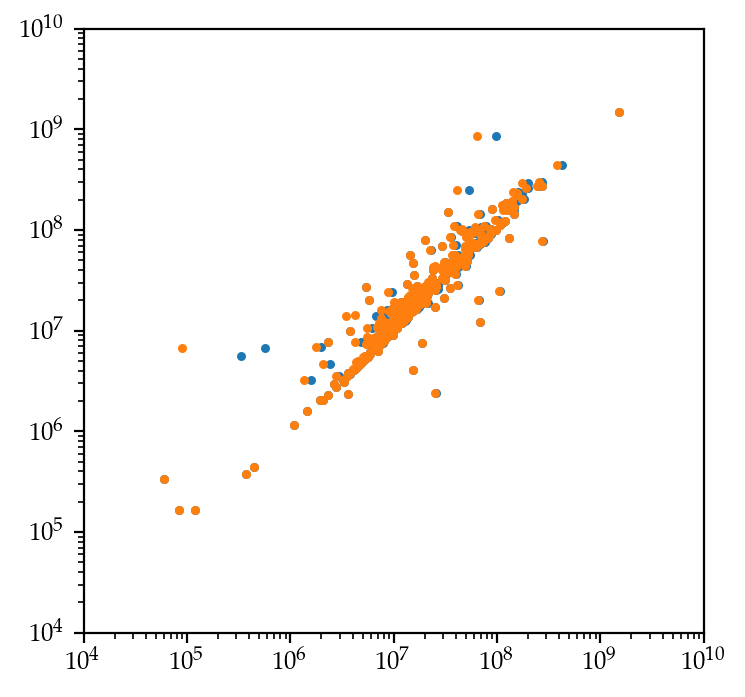

In [65]:
plt.figure(dpi=200, figsize=(4,4))
plt.scatter(data_all.Mdot_expelled - data_all.Mdot_accreted + data_all.SFR * 1e9, -data_all.Mdot_gas, s=5)
plt.scatter(data_all.Mdot_expelled - data_all.Mdot_accreted, -data_all.Mdot_gas, s=5)
plt.loglog()
plt.xlim(1e4, 1e10)
plt.ylim(1e4, 1e10)
plt.show()

(array([  1.,   0.,   0.,   1.,   0.,   2.,  38., 326.,   0.,   2.]),
 array([-3.04767173e-09, -2.62281155e-09, -2.19795138e-09, -1.77309120e-09,
        -1.34823102e-09, -9.23370844e-10, -4.98510667e-10, -7.36504902e-11,
         3.51209687e-10,  7.76069864e-10,  1.20093004e-09]),
 <BarContainer object of 10 artists>)

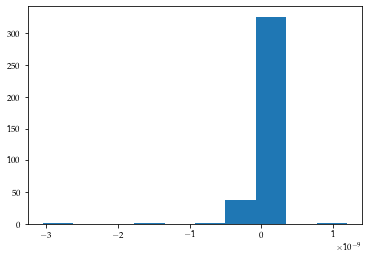

In [49]:
cond = ~np.isnan(y) & ~np.isinf(y)
plt.hist(y)

In [ ]:
plt.

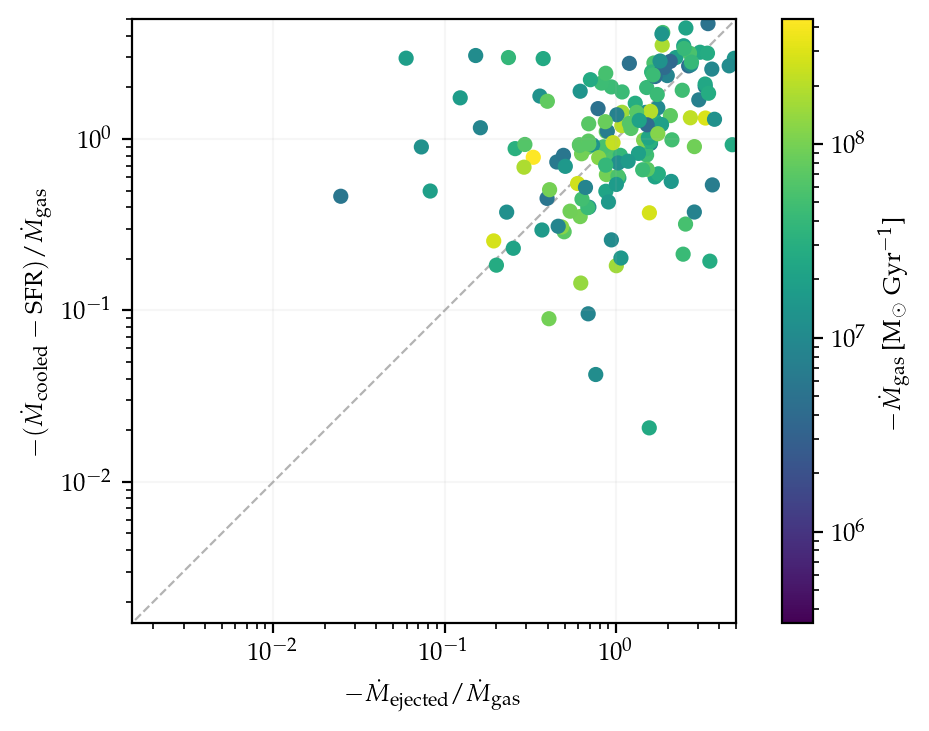

In [16]:
x = data_all.Mdot_ejected/data_all.Mdot_gas
y = (data_all.Mdot_cooled - data_all.sfr*1e9)/data_all.Mdot_gas
c = data_all.Mdot_gas
norm = mpl.colors.LogNorm()

fig, ax = plt.subplots(1,1,dpi=200)
im = ax.scatter(-x,-y,c=-c, norm=norm, s=20)
fig.colorbar(im, label=r'$-\dot{M}_{\rm gas}$ [M$_{\odot}$ Gyr$^{-1}$]')
ax.set_xlabel(r'$-\dot{M}_{\rm ejected}/\dot{M}_{\rm gas}$')
ax.set_ylabel(r'$-(\dot{M}_{\rm cooled}-{\rm SFR})/\dot{M}_{\rm gas}$')
ax.loglog()
ax.set_ylim(1.5e-3, 5)
ax.set_xlim(1.5e-3,5)
ax.plot([1e-3,10],[1e-3,10],'--', linewidth=0.8, color='0.7', zorder=-1000)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_aspect('equal')
plt.show()

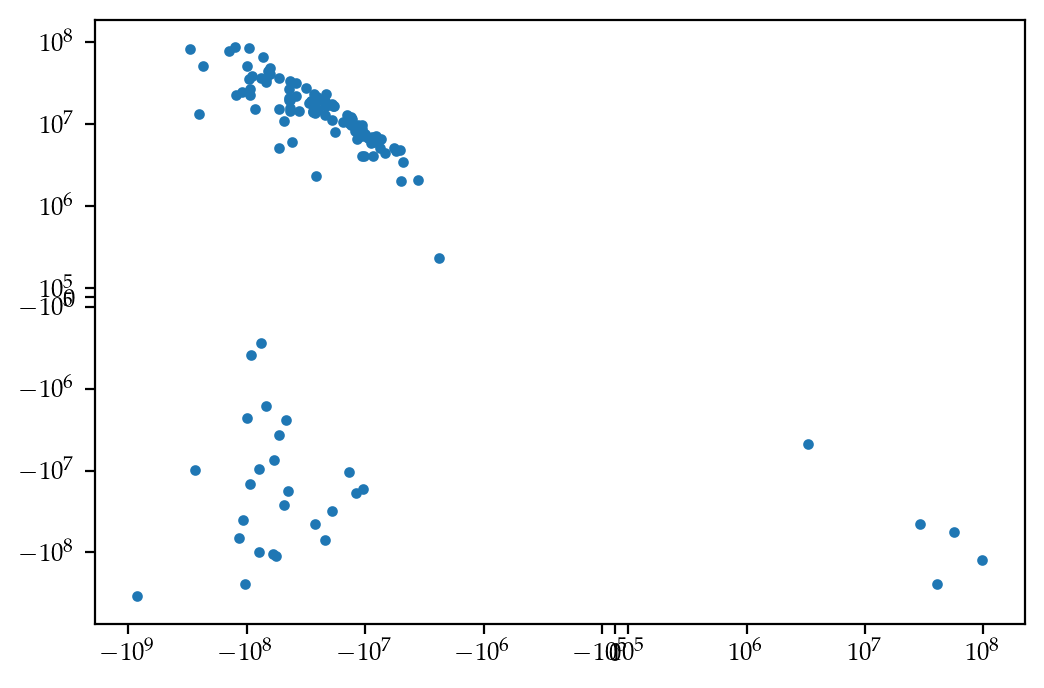

In [120]:
plt.figure(dpi=200)
plt.scatter(data_all.Mdot_gas, data_all.Mdot_expelled - data_all.Mdot_accreted, s=8)
plt.xscale('symlog', linthresh=1e6)
plt.yscale('symlog', linthresh=1e6)

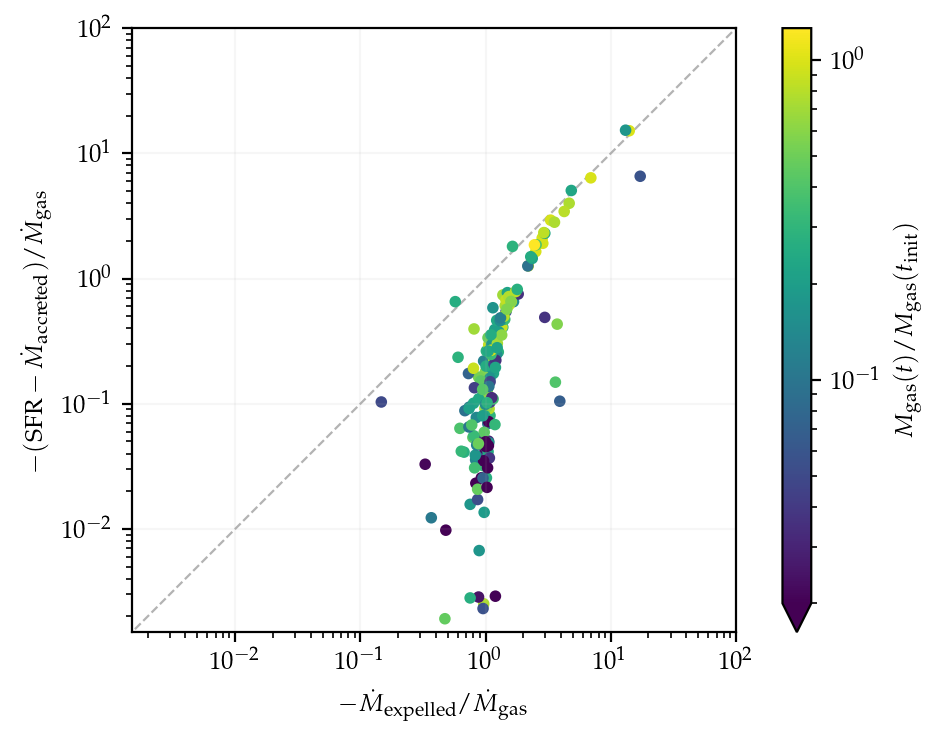

In [23]:
x = data_all.Mdot_expelled/data_all.Mdot_gas
y = (data_all.Mdot_accreted - data_all.sfr*1e9)/data_all.Mdot_gas
c = f_gas
norm = mpl.colors.LogNorm(vmin = 2e-2)

fig, ax = plt.subplots(1,1,dpi=200)
im = ax.scatter(-x,-y,c=c, norm=norm, s=10)
fig.colorbar(im, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$-\dot{M}_{\rm expelled}/\dot{M}_{\rm gas}$')
ax.set_ylabel(r'$-({\rm SFR} - \dot{M}_{\rm accreted})/\dot{M}_{\rm gas}$')
ax.loglog()
ax.set_ylim(1.5e-3, 1e2)
ax.set_xlim(1.5e-3,1e2)
ax.plot([1e-3,1e2],[1e-3,1e2],'--', linewidth=0.8, color='0.7', zorder=-1000)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_aspect('equal')
plt.show()

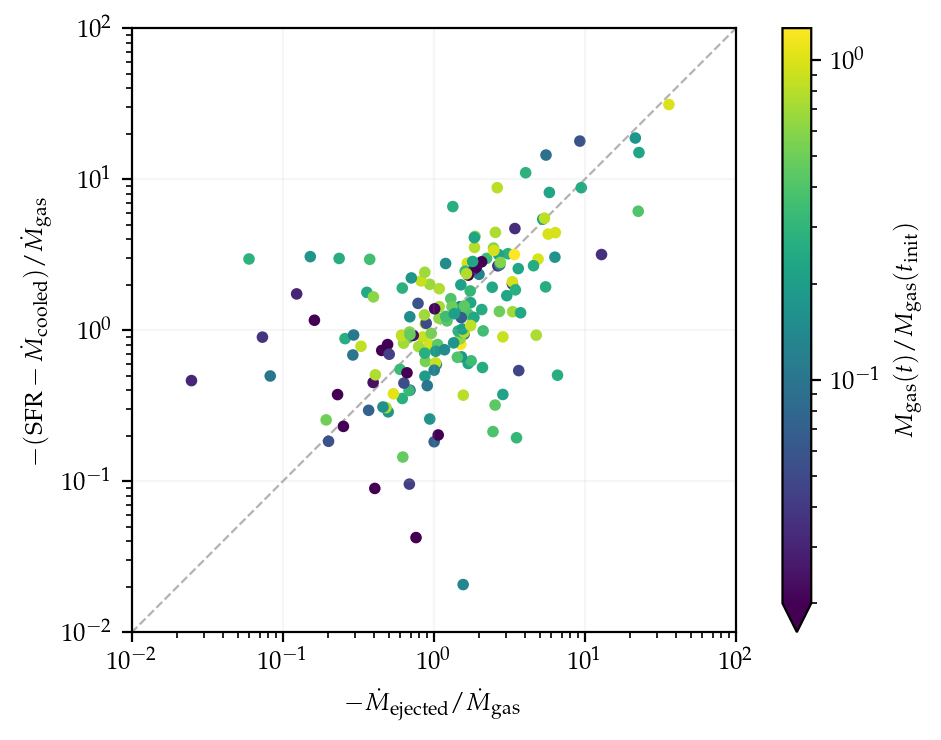

In [24]:
x = data_all.Mdot_ejected/data_all.Mdot_gas
y = (data_all.Mdot_cooled - data_all.sfr*1e9)/data_all.Mdot_gas
c = f_gas
norm = mpl.colors.LogNorm(vmin = 2e-2)

fig, ax = plt.subplots(1,1,dpi=200)
im = ax.scatter(-x,-y,c=c, norm=norm, s=10)
fig.colorbar(im, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$-\dot{M}_{\rm ejected}/\dot{M}_{\rm gas}$')
ax.set_ylabel(r'$-({\rm SFR} - \dot{M}_{\rm cooled})/\dot{M}_{\rm gas}$')
ax.loglog()
ax.set_ylim(1e-2,1e2)
ax.set_xlim(1e-2,1e2)
ax.plot([1e-3,1e2],[1e-3,1e2],'--', linewidth=0.8, color='0.7', zorder=-1000)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_aspect('equal')
plt.show()

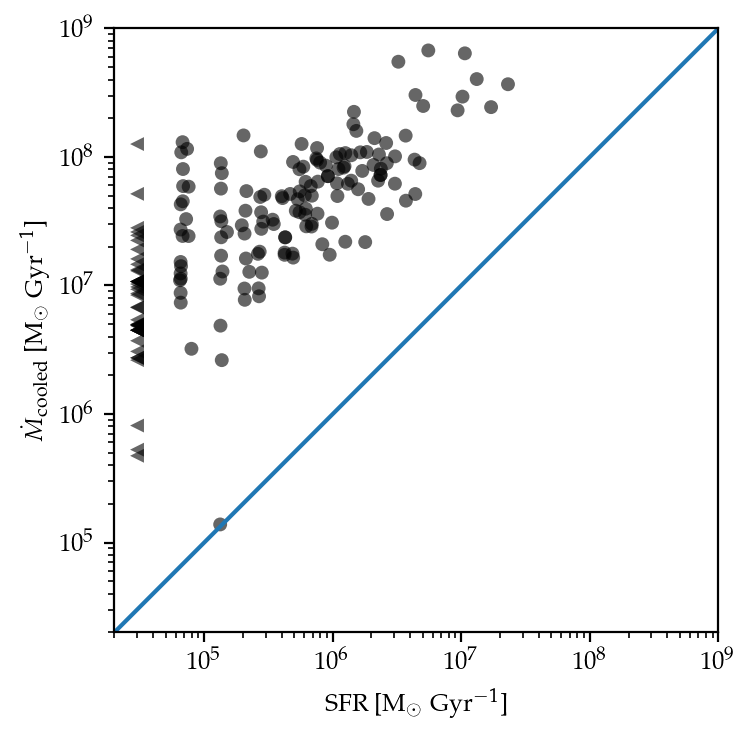

In [43]:
plt.figure(dpi=200, figsize=(4,4))
plt.scatter(data_all.sfr*1e9, data_all.Mdot_cooled, s=25, ec='none', fc='k', alpha=0.6)
plt.scatter([3e4]*len(data_all[data_all.sfr==0]), data_all.Mdot_cooled[data_all.sfr==0], marker='<', s=25, ec='none', fc='k', alpha=0.6)
plt.loglog()
plt.gca().set_aspect('equal')
plt.xlim(2e4, 1e9)
plt.ylim(2e4, 1e9)
plt.axline((1e4,1e4),(1e9,1e9))
plt.xlabel(r'SFR [M$_{\odot}$ Gyr$^{-1}$]')
plt.ylabel(r'$\dot{M}_{\rm cooled}$ [M$_{\odot}$ Gyr$^{-1}$]')
plt.show()


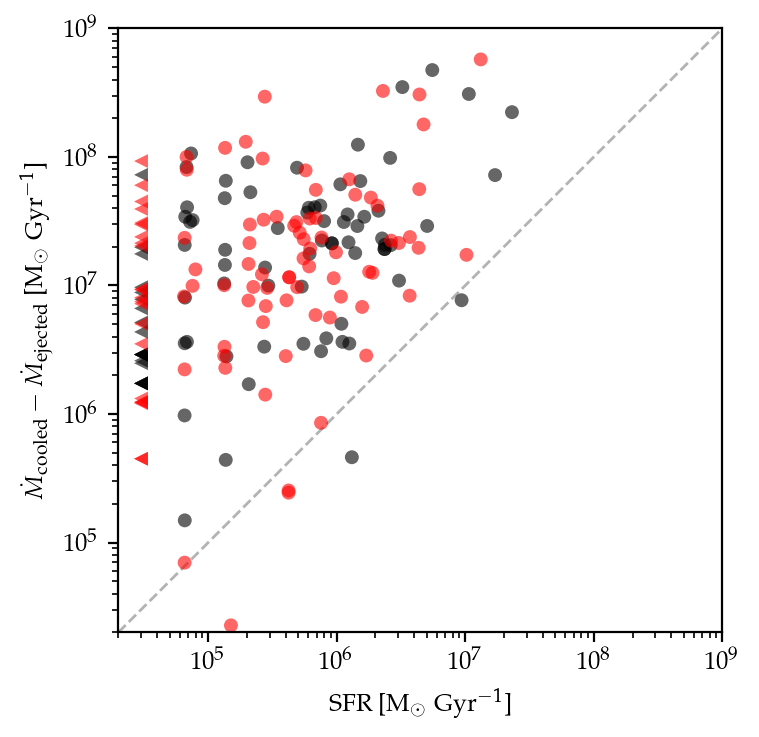

In [54]:
plt.figure(dpi=200, figsize=(4,4))
plt.scatter(data_all.sfr*1e9, data_all.Mdot_cooled-data_all.Mdot_ejected, s=25, ec='none', fc='k', alpha=0.6)
plt.scatter([3e4]*len(data_all[data_all.sfr==0]), (data_all.Mdot_cooled-data_all.Mdot_ejected)[data_all.sfr==0], marker='<', s=25, ec='none', fc='k', alpha=0.6)
plt.scatter(data_all.sfr*1e9, data_all.Mdot_ejected-data_all.Mdot_cooled, s=25, ec='none', fc='r', alpha=0.6)
plt.scatter([3e4]*len(data_all[data_all.sfr==0]), (data_all.Mdot_ejected-data_all.Mdot_cooled)[data_all.sfr==0], marker='<', s=25, ec='none', fc='r', alpha=0.6)

plt.loglog()
plt.gca().set_aspect('equal')
plt.xlim(2e4, 1e9)
plt.ylim(2e4, 1e9)
plt.axline((1e4,1e4),(1e9,1e9), color='0.7', zorder=-1000, linewidth=1, linestyle='--')
plt.xlabel(r'SFR [M$_{\odot}$ Gyr$^{-1}$]')
plt.ylabel(r'$\dot{M}_{\rm cooled} - \dot{M}_{\rm ejected}$ [M$_{\odot}$ Gyr$^{-1}$]')
plt.show()


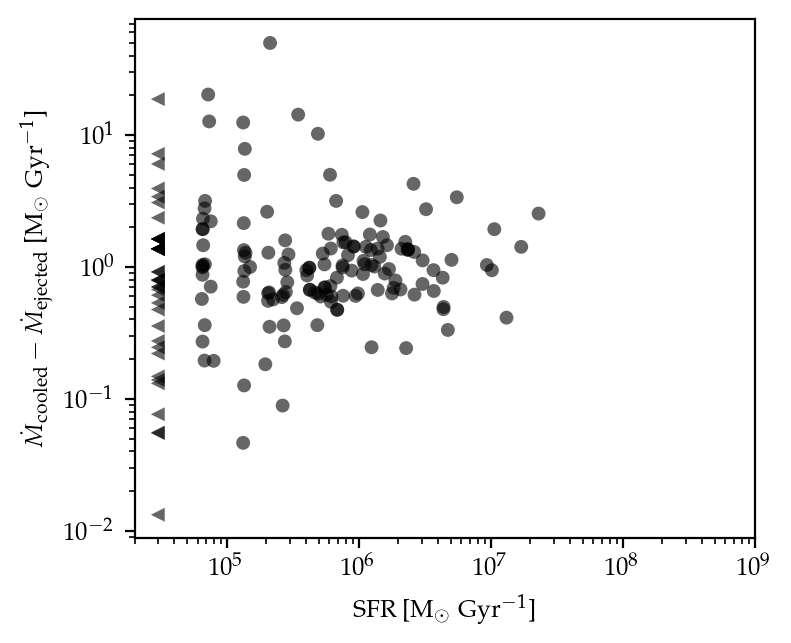

In [80]:
plt.figure(dpi=200, figsize=(4,4))
plt.scatter(data_all.sfr*1e9, data_all.Mdot_cooled/data_all.Mdot_ejected, s=25, ec='none', fc='k', alpha=0.6)
plt.scatter([3e4]*len(data_all[data_all.sfr==0]), (data_all.Mdot_cooled/data_all.Mdot_ejected)[data_all.sfr==0], marker='<', s=25, ec='none', fc='k', alpha=0.6)

plt.loglog()
plt.gca().set_aspect('equal')
plt.xlim(2e4, 1e9)
# plt.ylim(2e4, 1e9)
plt.xlabel(r'SFR [M$_{\odot}$ Gyr$^{-1}$]')
plt.ylabel(r'$\dot{M}_{\rm cooled} - \dot{M}_{\rm ejected}$ [M$_{\odot}$ Gyr$^{-1}$]')
plt.show()


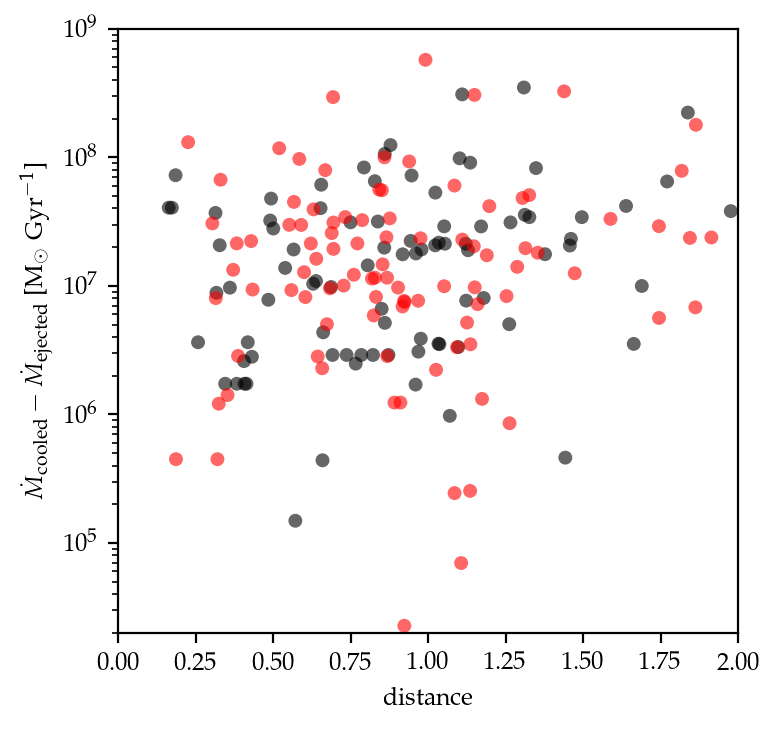

In [75]:
plt.figure(dpi=200, figsize=(4,4))
plt.scatter(data_all.h1dist/data_all.hostRvir, data_all.Mdot_cooled-data_all.Mdot_ejected, s=25, ec='none', fc='k', alpha=0.6)
plt.scatter([3e4]*len(data_all[data_all.sfr==0]), (data_all.Mdot_cooled-data_all.Mdot_ejected)[data_all.sfr==0], marker='<', s=25, ec='none', fc='k', alpha=0.6)
plt.scatter(data_all.h1dist/data_all.hostRvir, data_all.Mdot_ejected-data_all.Mdot_cooled, s=25, ec='none', fc='r', alpha=0.6)
plt.scatter([3e4]*len(data_all[data_all.sfr==0]), (data_all.Mdot_ejected-data_all.Mdot_cooled)[data_all.sfr==0], marker='<', s=25, ec='none', fc='r', alpha=0.6)

plt.semilogy()
# plt.gca().set_aspect('equal')
plt.xlim(0, 2)
plt.ylim(2e4, 1e9)
# plt.axline((1e4,1e4),(1e9,1e9), color='0.7', zorder=-1000, linewidth=1, linestyle='--')
plt.xlabel(r'distance')
plt.ylabel(r'$\dot{M}_{\rm cooled} - \dot{M}_{\rm ejected}$ [M$_{\odot}$ Gyr$^{-1}$]')
plt.show()


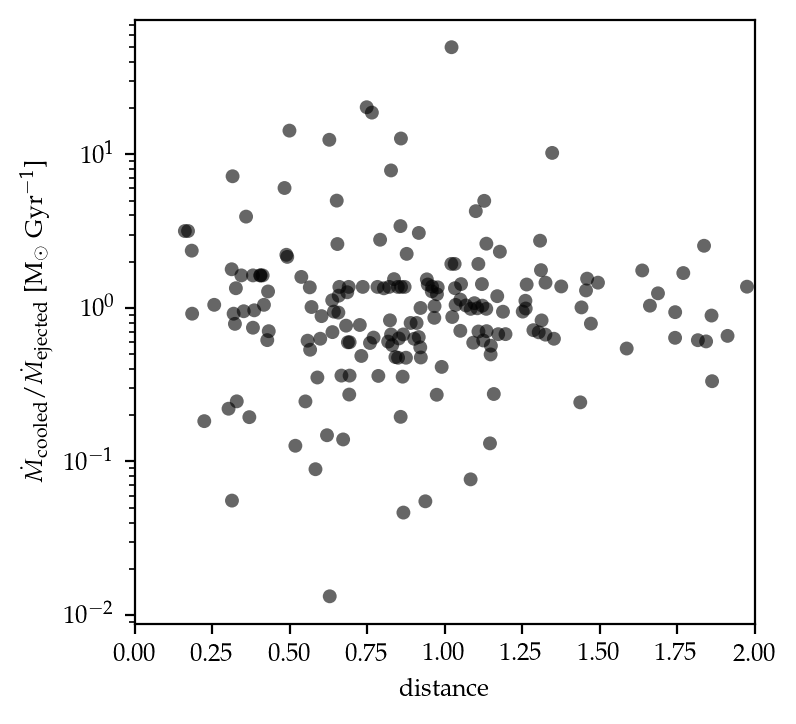

In [77]:
plt.figure(dpi=200, figsize=(4,4))
plt.scatter(data_all.h1dist/data_all.hostRvir, data_all.Mdot_cooled/data_all.Mdot_ejected, s=25, ec='none', fc='k', alpha=0.6)

plt.semilogy()
# plt.gca().set_aspect('equal')
plt.xlim(0, 2)
# plt.ylim(2e4, 1e9)
# plt.axline((1e4,1e4),(1e9,1e9), color='0.7', zorder=-1000, linewidth=1, linestyle='--')
plt.xlabel(r'distance')
plt.ylabel(r'$\dot{M}_{\rm cooled} / \dot{M}_{\rm ejected}$ [M$_{\odot}$ Gyr$^{-1}$]')
plt.show()


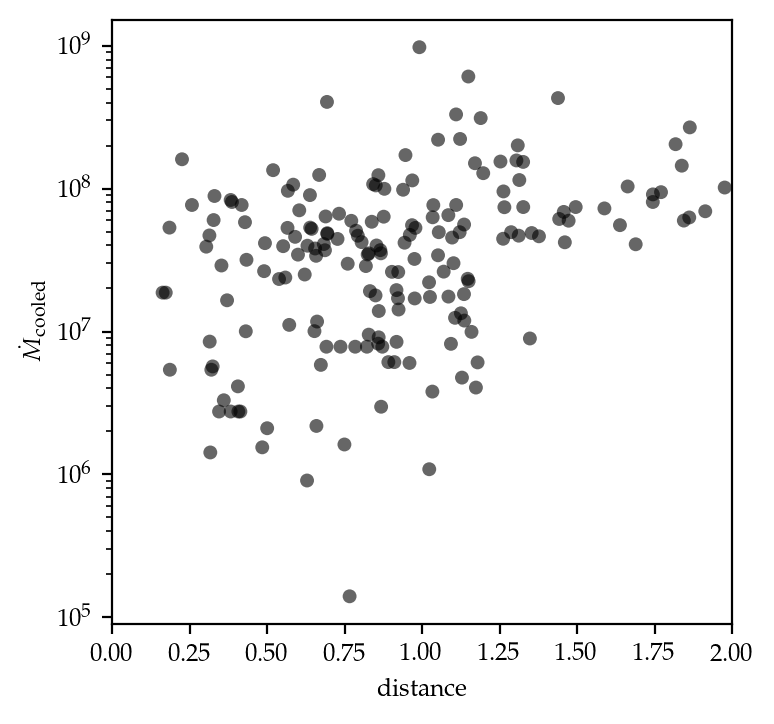

In [82]:
plt.figure(dpi=200, figsize=(4,4))
plt.scatter(data_all.h1dist/data_all.hostRvir, data_all.Mdot_ejected, s=25, ec='none', fc='k', alpha=0.6)

plt.semilogy()
# plt.gca().set_aspect('equal')
plt.xlim(0, 2)
# plt.ylim(2e4, 1e9)
# plt.axline((1e4,1e4),(1e9,1e9), color='0.7', zorder=-1000, linewidth=1, linestyle='--')
plt.xlabel(r'distance')
plt.ylabel(r'$\dot{M}_{\rm cooled}$')
plt.show()


In [73]:
print(f'{np.min(np.abs(data_all.Mdot_ejected-data_all.Mdot_cooled)):.2e}')

2.27e+04


In [65]:
particles = read_tracked_particles('h229',22)
print(f'The median gas particle mass is {np.median(particles.mass):.2e} Msun')
print(f'The median delta t between snapshots is {np.median(data_all.dt):.2f} Gyr')
print(f'The resolution limit for Mdot, for the median gas particle, is {np.median(particles.mass)/np.mean(data_all.dt):.2e} Msun/Gyr')

print(f'{np.max(particles.mass)/np.min(data_all.dt):.2e}')


The median gas particle mass is 2.66e+04 Msun
The median delta t between snapshots is 0.32 Gyr
The resolution limit for Mdot, for the median gas particle, is 8.76e+04 Msun/Gyr
5.62e+06


In [34]:
data_all.Mdot_cooled[data_all.sfr==0]

19    2.622589e+06
11    5.402742e+06
14    4.988117e+06
17    3.067325e+06
12    2.804738e+07
14    1.323064e+07
18    5.277126e+05
19    9.339113e+06
20    4.952711e+06
21    4.952711e+06
18    2.605233e+07
24    8.415681e+06
25    2.733049e+06
26    2.733049e+06
22    1.258612e+08
24    2.240260e+07
25    1.459941e+07
26    3.712575e+06
27    8.124106e+05
30    9.733975e+06
34    4.486596e+06
35    4.727136e+05
36    1.025176e+07
37    4.485144e+06
38    4.485144e+06
39    4.485144e+06
40    4.485144e+06
41    6.727715e+06
22    6.776850e+06
23    4.870861e+06
24    4.870861e+06
25    1.072468e+07
26    1.906609e+07
27    2.451354e+07
28    1.072468e+07
29    1.072468e+07
30    1.072468e+07
31    1.072468e+07
32    1.608701e+07
14    5.155706e+07
26    8.654388e+06
27    1.298158e+07
Name: Mdot_cooled, dtype: float64

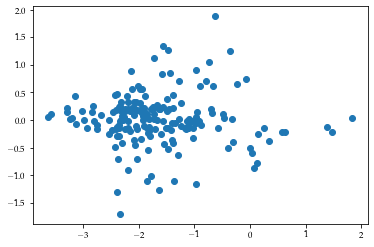

In [71]:
plt.scatter(np.log10(data_all.ratio), np.log10(data_all.Mdot_ejected/data_all.Mdot_cooled))

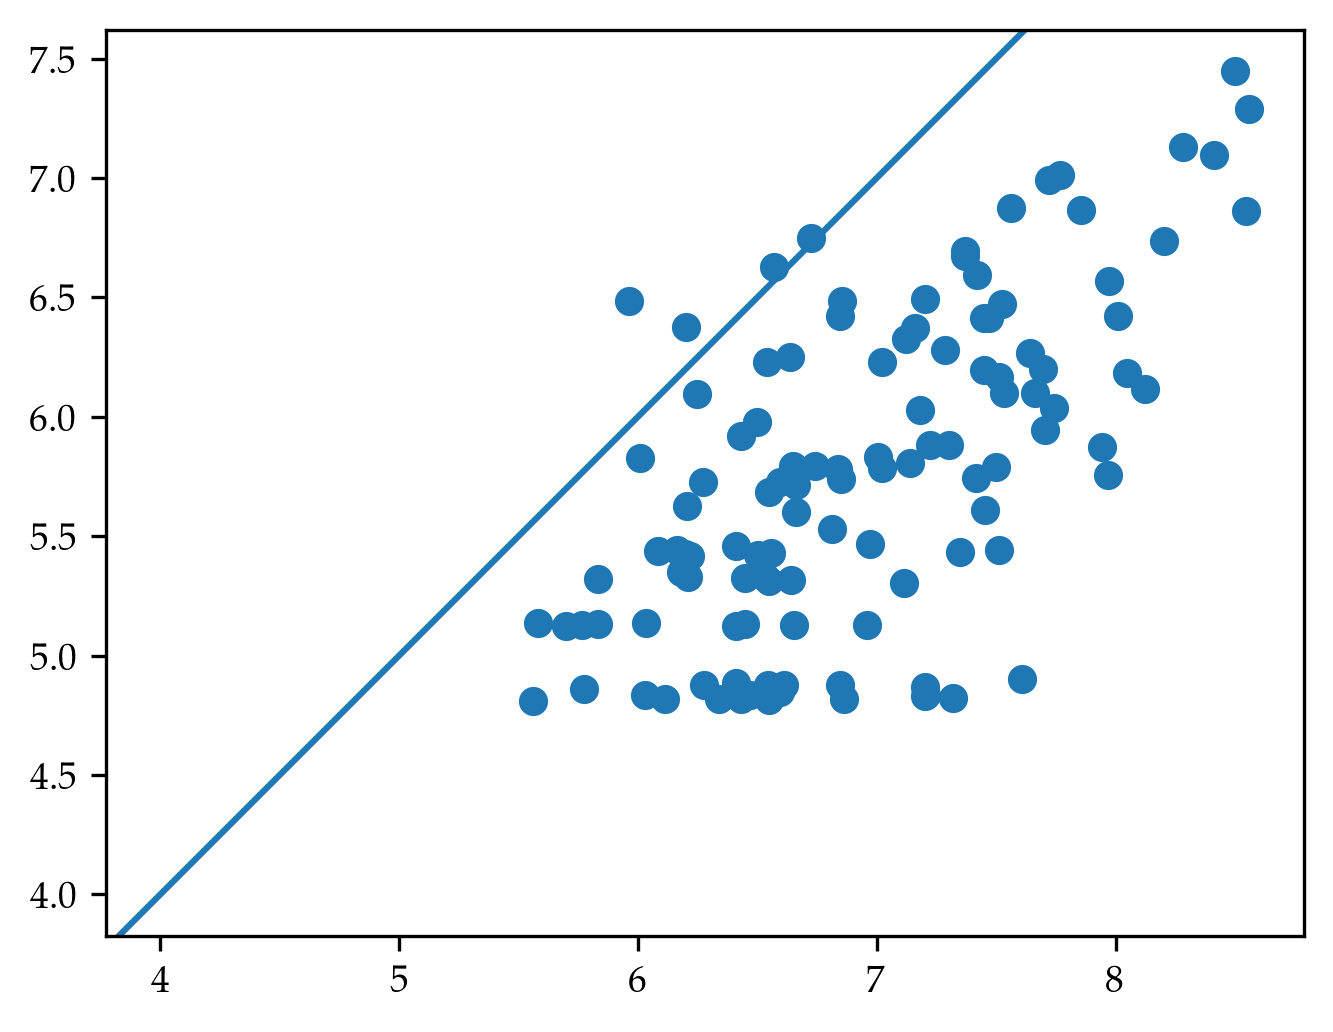

In [142]:
plt.figure(dpi=300)
plt.scatter(np.log10(data_all.Mdot_accreted), np.log10(data_all.sfr*1e9))
plt.axline((4,4),slope=1)
plt.gca().set_aspect('equal')
plt.show()

In every case, ${\rm SFR} > \dot{M}_{\rm accreted}$ 

Upper left side of this plot: gas consumption is greater than gas expulsion. **This generally seems to be because expulsion rates are low, while consumption rates
Lower right side of thsi plot: gas expulsion is greater than gas consumption. 

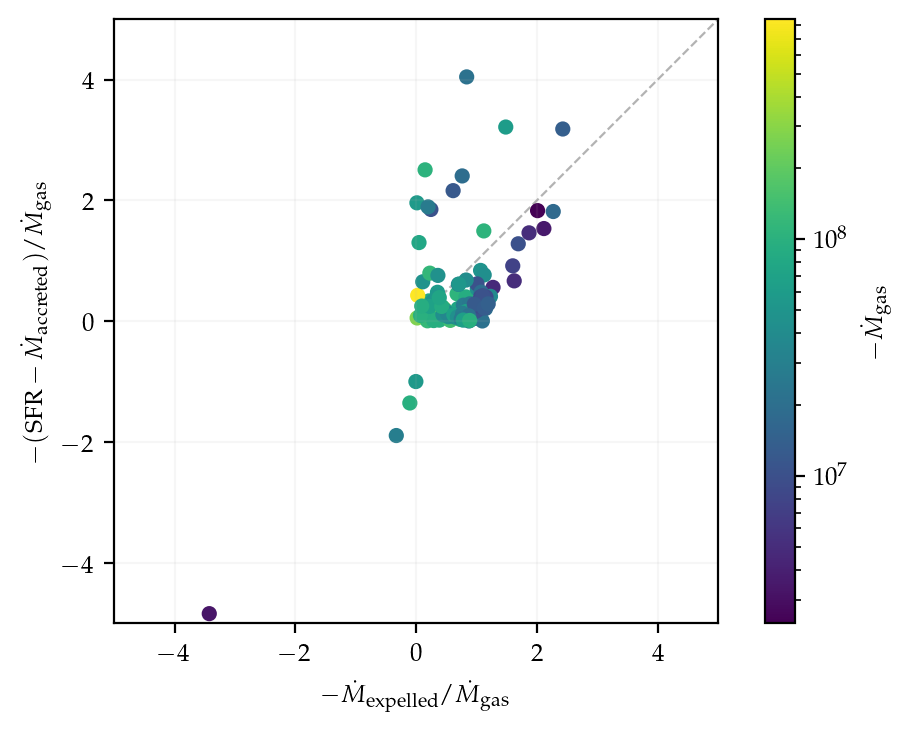

In [71]:
x = data_all.Mdot_expelled/data_all.Mdot_gas
y = (data_all.Mdot_accreted - data_all.sfr/1e9)/data_all.Mdot_gas
c = data_all.Mdot_gas
norm = mpl.colors.LogNorm()

fig, ax = plt.subplots(1,1,dpi=200)
im = ax.scatter(-x,-y,c=-c, norm=norm, s=20)
im = ax.scatter(-x,-y,c=c, norm=norm, s=20)
fig.colorbar(im, label=r'$-\dot{M}_{\rm gas}$')
ax.set_xlabel(r'$-\dot{M}_{\rm expelled}/\dot{M}_{\rm gas}$')
ax.set_ylabel(r'$-({\rm SFR} - \dot{M}_{\rm accreted})/\dot{M}_{\rm gas}$')
# ax.loglog()
ax.set_ylim(-5, 5)
ax.set_xlim(-5,5)
ax.plot([1e-3,10],[1e-3,10],'--', linewidth=0.8, color='0.7', zorder=-1000)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_aspect('equal')
plt.show()

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([1., 1., 1., 1., 0., 0., 0., 1., 0., 1.]),
 array([5.68139315e-05, 8.91474475e-02, 1.78238081e-01, 2.67328715e-01,
        3.56419348e-01, 4.45509982e-01, 5.34600616e-01, 6.23691249e-01,
        7.12781883e-01, 8.01872516e-01, 8.90963150e-01]),
 <BarContainer object of 10 artists>)

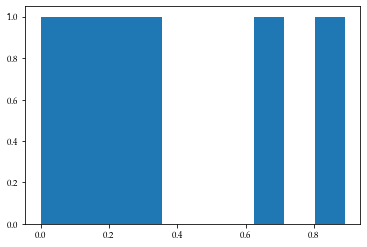

In [58]:

plt.hist(np.log10(np.array(y,dtype=float)))

In [69]:
#len(y[y > 0])/len(y)
c[y > 0]

2     2.047945e+08
6     4.083470e+07
4     9.764318e+07
5     2.906474e+07
16    3.323510e+06
27    5.664501e+07
Name: Mdot_gas, dtype: float64

In [38]:
data_all.Mdot_gas

0              NaN
1    -1.418639e+07
2    -5.685701e+07
3    -7.848485e+07
4    -2.749998e+08
          ...     
23   -2.125072e+07
24   -2.642608e+07
25   -6.372182e+07
26   -9.673122e+07
27    5.664501e+07
Name: Mdot_gas, Length: 141, dtype: float64